# 2024-1 DSL 정규세션 과제

## Unsupervised Learning

- 작성자 : 윤형진
- 참고자료 : 10기 비지도학습 과제 (Special Thaks to 9기 장현빈), sklearn/scipy document
- 과제 제출 기한 : 02.03

---
- 이름 : 임창재
- 기수 : 10기



# Colab 환경에서의 실습을 권장드립니다!! (umap-learn library 이슈)

# Table of Contents

* [1 | Dimension Reduction Review](#chapter1)
    * [1-1 | Dimension Reduction Algorithms](#section_1_1)
    * [1-2 | Implementation](#section_1_2)
* [2 | Dimension Reduction Exercise](#chapter2)
    * [2-1 | 🥎 Spherical Data](#section_2_1)
    * [2-2 | 🌈 S-curve Data](#section_2_2)
    * [2-3 | PCA and Explained Variance](#section_2_3)
    * [2-4 | scRNA-seq Data](#section_2_4)
* [3 | Clustering Review & Exercise](#chapter3)
    * [3-1 | Implementation](#section_3_1)
    * [3-2 | Exercise](#section_3_2)

# 1. Session Review <a class="anchor" id="chapter1"></a>





## 1-1 | Dimension Reduction Algorithms <a class="anchor" id="section_1_1"></a>

1. Linear Dimension Reduction
  - PCA : 공분산 행렬의 고유벡터 (Principal Component)
  - MDS : 데이터간 거리 보존
2. Non-Linear Dimension Reduction
  - KPCA : kernel trick을 이용한 PCA
  - Isomap : High dimension manifold에서의 geodesic 거리를 이용한 MDS
  - LLE : 비선형 데이터의 국소 선형성을 이용한 데이터 복원 아이디어
  - t-SNE : t-분포를 이용하여 유사도가 높/낮은 데이터의 분포를 배우는 알고리즘 (KL-divergence)
  - UMAP : t-SNE와 비슷하나, 다른 함수를 이용하여 축소된 차원에서의 embedding을 배우는 알고리즘 (Cross Entropy)

## 1-2 | Implementation <a class="anchor" id="section_1_2"></a>

- 각 알고리즘 `class`로부터 `reducer_instance`를 초기화하여 사용합니다.
- 실제로 `데이터`를 축소할 때는, `reducer_instance.fit_transform(데이터)`의 형태로 사용합니다

<br></br>

1. `from sklearn import` `manifold`

  1.  MDS : `manifold.MDS(n_components = 목표 차원, max_iter = 최대 이터레이션 수, n_init = 알고리즘이 초기화될 횟수 (가장 좋은 결과가 반환됨), random_state = 클러스터 중심 초기화 재현을 위한 random state 지정)`
  2. Isomap : `manifold.Isomap(n_neighbors = 이웃수, n_components = 목표 차원)`
  3. LLE : `manifold.LocallyLinearEmbedding(n_neighbors = 이웃수, n_components = 목표 차원)`
  4. t-SNE : `manifold.TSNE(n_components = 목표 차원, random_state = 데이터 포인트 임베딩 랜덤 초기화의 재현을 위한 random state 지정)`

<br></br>

2. `from sklearn import` `decomposition`

  1. PCA : `decomposition.PCA(n_components = 목표 차원)`
  2. KPCA : `decomposition.PCA(n_components = 목표 차원, kernel = 커널 종류 지정)`


<br></br>

3. `import` `umap`

  1. UMAP : `umap.UMAP(n_components = 목표 차원, metric = 유사도 측정 매트릭, n_neighbors = 유사도 계산 시 포함할 이웃 데이터 포인트의 수)`
  - 출처 : https://umap-learn.readthedocs.io/en/latest/parameters.html


# 2. Exercise <a class="anchor" id="chapter2"></a>

- 해당 섹션부터는 앞서 리뷰한 내용을 바탕으로 7가지 차원축소 알고리즘이 데이터를 어떻게 차원축소 시키는지 시각화해봅시다

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2-1 | Spherical Data <a class="anchor" id="section_2_1"></a>

In [1]:
# numpy + pandas
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# time
from time import time
import warnings
warnings.filterwarnings('ignore')

# matplotlib
import mpl_toolkits.mplot3d
import numpy as np
from matplotlib.ticker import NullFormatter

In [2]:
!pip install umap-learn -q # umap 라이브러리의 경우 표준 라이브러리가 아니기 때문에 따로 설치해줍니다

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.3 MB/s eta 0:00:00


In [3]:
from sklearn.utils import check_random_state
from sklearn import manifold, decomposition, datasets
from matplotlib import ticker
import umap

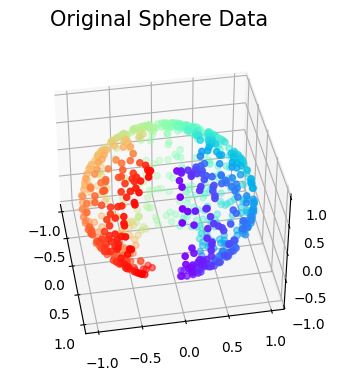

In [4]:
#차원 축소 학습을 진행하기 위한 변수를 설정해줍니다.
n_neighbors = 10
n_samples = 1000

#원본이 되는 기하학적인 구형 데이터를 만들어줍니다.
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

indices = (t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8)))
colors = p[indices]
x, y, z = (
    np.sin(t[indices]) * np.cos(p[indices]),
    np.sin(t[indices]) * np.sin(p[indices]),
    np.cos(t[indices]),
)

#3차원 원본 데이터를 확인해봅시다!
fig = plt.figure(figsize=(4, 4))
plt.suptitle(
    "Original Sphere Data", fontsize=15
)

ax = fig.add_subplot(projection="3d")
ax.scatter(x, y, z, c=colors, cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T
plt.show()

In [5]:
["PCA", "MDS", "KPCA", "Isomap", "LLE", "t-SNE"]

['PCA', 'MDS', 'KPCA', 'Isomap', 'LLE', 't-SNE']

PCA: 0.023 sec
MDS: 2.2 sec
KPCA: 3.3e-06 sec
Isomap: 0.68 sec
LLE: 0.39 sec
t-SNE: 23 sec
UMAP: 13 sec


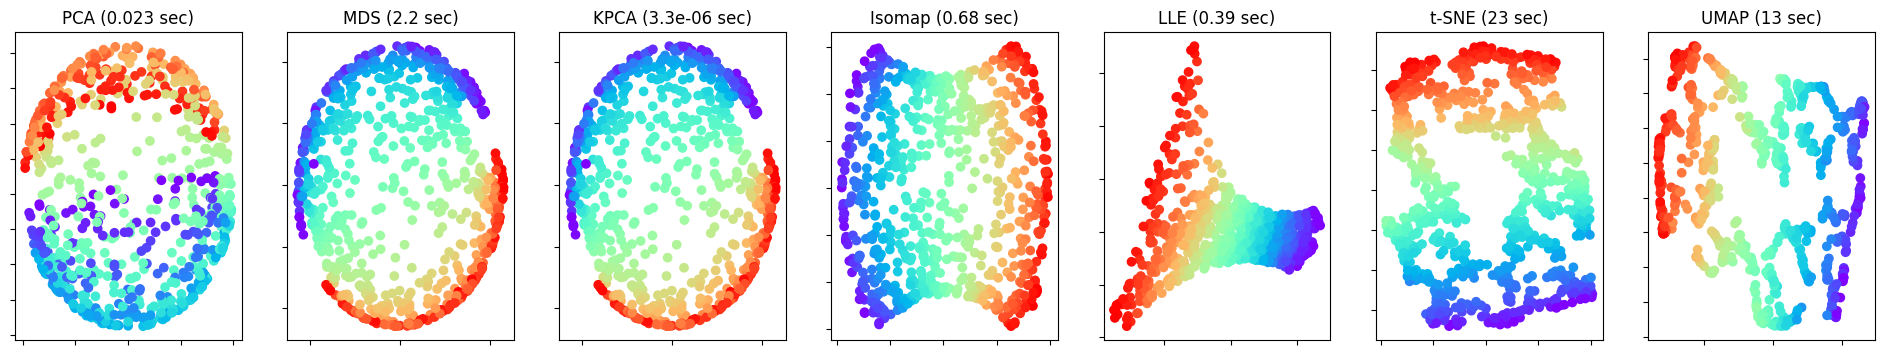

In [6]:
#여러 가지 차원 축소 알고리즘을 사용해봅시다.
feature_extraction = ["PCA", "MDS", "KPCA", "Isomap", "LLE", "t-SNE", "UMAP"]

plots = []
fig, axes = plt.subplots(nrows=1, ncols=len(feature_extraction), figsize=(24, 4))

#세션에서 다룬 Unsupervised feature extraction 알고리즘들을 적용해봅시다!
for i, algorithm in enumerate(feature_extraction, start=1):
    t0 = time()

    if algorithm == "PCA":
        pca = decomposition.PCA(n_components=2)
        trans_data = pca.fit_transform(sphere_data).T

    elif algorithm == "MDS":
        mds = manifold.MDS(n_components=2, max_iter=100, n_init=1, random_state=0)
        trans_data = mds.fit_transform(sphere_data).T

    elif algorithm == "KernelPCA":
        kernel_pca = decomposition.KernelPCA(n_components=2, kernel='rbf')
        trans_data = kernel_pca.fit_transform(sphere_data).T

    elif algorithm == "Isomap":
        trans_data = manifold.Isomap(n_neighbors=n_neighbors, n_components=2).fit_transform(sphere_data).T

    elif algorithm == "LLE":
        trans_data = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2).fit_transform(sphere_data).T

    elif algorithm == "t-SNE":
        tsne = manifold.TSNE(n_components=2, random_state=0)
        trans_data = tsne.fit_transform(sphere_data).T

    elif algorithm == "UMAP":
        umap_ = umap.UMAP()
        trans_data = umap_.fit_transform(sphere_data).T

    t1 = time()
    print("%s: %.2g sec" % (algorithm, t1 - t0))

    ax = axes[i - 1]
    ax.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
    ax.set_title("%s (%.2g sec)" % (algorithm, t1 - t0))
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.axis("tight")

plt.show()

## 2-2 | S-curve Data <a class="anchor" id="section_2_2"></a>

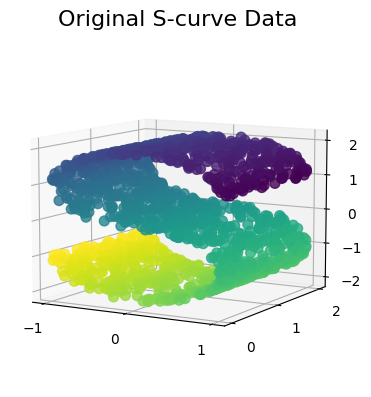

In [8]:
#sample의 수를 지정해줍니다.
n_samples = 1500
S_points, S_color = datasets.make_s_curve(n_samples, random_state=0)

#원본이 되는 기하학적 구조의 S-curve Data를 만들어봅시다.
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(4, 4),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

plot_3d(S_points, S_color, "Original S-curve Data")

PCA: 0.0022 sec
MDS: 6.8 sec
KPCA: 3.3e-06 sec
Isomap: 1.2 sec
LLE: 0.25 sec
t-SNE: 12 sec
UMAP: 5.1 sec


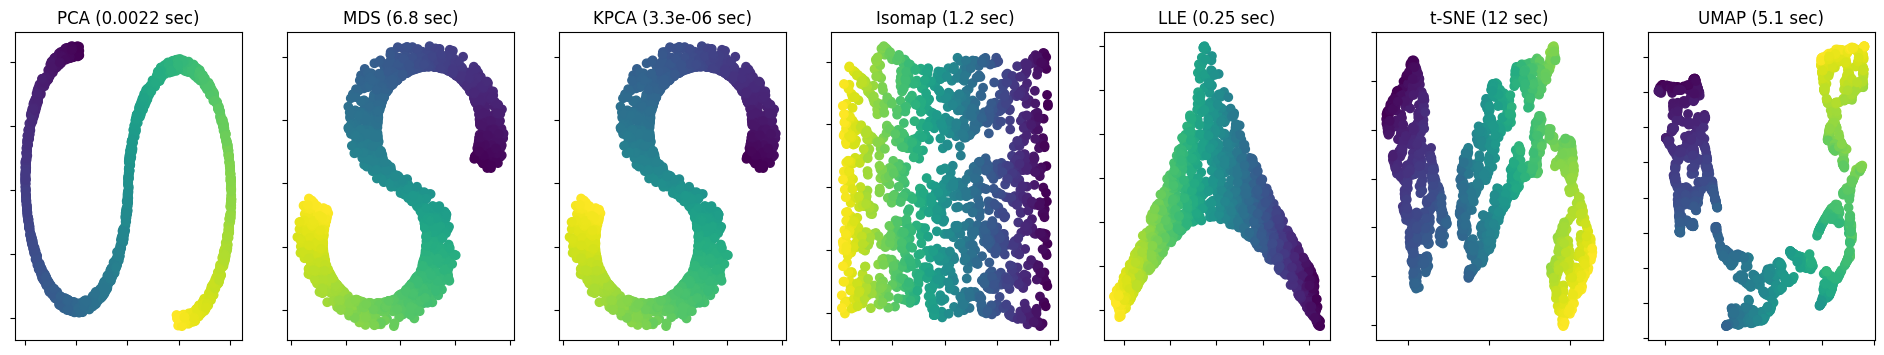

In [9]:
#여러 가지 차원 축소 알고리즘을 사용해봅시다.
feature_extraction = ["PCA", "MDS", "KPCA", "Isomap", "LLE", "t-SNE", "UMAP"]

plots = []
fig, axes = plt.subplots(nrows=1, ncols=len(feature_extraction), figsize=(24, 4))

#세션에서 다룬 Unsupervised feature extraction 알고리즘들을 적용해봅시다!
for i, algorithm in enumerate(feature_extraction):
    t0 = time()

    if algorithm == "PCA":
        pca = decomposition.PCA(n_components=2)
        trans_data = pca.fit_transform(S_points).T

    elif algorithm == "MDS":
        mds = manifold.MDS(n_components=2, max_iter=100, n_init=1, random_state=0)
        trans_data = mds.fit_transform(S_points).T

    elif algorithm == "KernelPCA":
        kernel_pca = decomposition.KernelPCA(n_components=2, kernel='rbf')
        trans_data = kernel_pca.fit_transform(S_points).T

    elif algorithm == "Isomap":
        trans_data = manifold.Isomap(n_neighbors=n_neighbors, n_components=2).fit_transform(S_points).T

    elif algorithm == "LLE":
        trans_data = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2).fit_transform(S_points).T

    elif algorithm == "t-SNE":
        tsne = manifold.TSNE(n_components=2, random_state=0)
        trans_data = tsne.fit_transform(S_points).T

    elif algorithm == "UMAP":
        umap_ = umap.UMAP()
        trans_data = umap_.fit_transform(S_points).T

    t1 = time()
    print("%s: %.2g sec" % (algorithm, t1 - t0))

    axes[i].scatter(trans_data[0], trans_data[1], c=S_color)
    axes[i].set_title("%s (%.2g sec)" % (algorithm, t1 - t0))
    axes[i].xaxis.set_major_formatter(ticker.NullFormatter())
    axes[i].yaxis.set_major_formatter(ticker.NullFormatter())
    axes[i].axis("tight")

plt.show()

## 2-3 | PCA and Explained variance <a class="anchor" id="section_2_3"></a>

In [18]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import time

# iris 데이터 불러오기(라벨을 제거한 데이터)
data = pd.read_csv('/content/drive/MyDrive/Regression_SVM_UnsupervisedLearning_ChangjaeIm/Unsupervised Learning/iris_data.csv')
print(data.head())

# 데이터를 스케일링 해줍니다
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [21]:
pca = PCA(n_components = 4) #feature의 수만큼 PCA를 수행해 주세요.(hint: 위의 데이터 프레임을 확인해보세요!)
pca_data = pca.fit_transform(scaled_data)

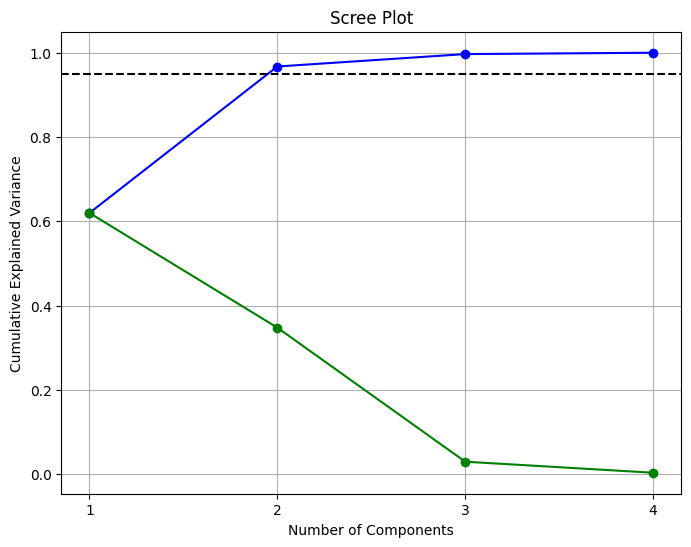

In [22]:
# pca 인스턴스로부터 explaine_variance_ratio_ attribute을 받아옵니다
explained_variance = pca.explained_variance_ratio_

# 설명되는 누적 분산량을 계산합니다
cumulative_variance = np.cumsum(explained_variance)

# 주성분에 따라 변화하는 설명량/누적 설명량을 그립니다
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='g')

plt.xticks(np.arange(1, len(explained_variance) + 1, step=1))

# y축 값이 0.95인 위치에 수평선을 그립니다
plt.axhline(y=0.95, color='black', linestyle='--')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid()
plt.show()


## 2-4 | Sinigle Cell RNA Sequencing Data <a class="anchor" id="section_2_4"></a>

개별 세포 수준의 유전정보를 파악하여 환자 맞춤형 정밀의료를 제공하는 미래는 올까요? Single Cell RNA Sequencing은 세포 하나하나에서 발현되고 있는 유전자 정보를 프로파일링하는 기술로, 정밀의료분야의 핵심 기술로 꼽히고 있습니다.

하지만, 사람 한 명에는 약 40조개의 세포가 있고, 개별 세포에서 발현되는 유전자의 수 또한 수만개에 이릅니다. 이런 고차원의 정보를 효율적으로 분석하기 위해서는 차원축소를 통한 데이터 전처리가 필수적이며, 그 중 t-SNE, UMAP이 대표적으로 사용되고 있습니다.

해당 섹션에서는 mouse model에서 얻은 뇌종양 조직 데이터셋에 t-SNE, UMAP 등을 적용해보고 그 결과를 간단히 해석해보겠습니다.

<br></br>

Reference : Huang, X., Henck, J., Qiu, C. et al. Single-cell, whole-embryo phenotyping of mammalian developmental disorders. Nature 623, 772–781 (2023). https://doi.org/10.1038/s41586-023-06548-w



In [26]:
# Normalization은 대학원생(진)이 끝냈으니 안심하고 로드합시다
seq_raw = pd.read_csv("/content/drive/MyDrive/Regression_SVM_UnsupervisedLearning_ChangjaeIm/Unsupervised Learning/scRNA-seq.csv")
seq_raw.head()

0         1         2         3    4         5    6         7         8  \
0  0.0  0.000000  0.000000  3.020854  0.0  6.617663  0.0  6.087970  0.000000   
1  0.0  0.000000  0.000000  2.698628  0.0  0.000000  0.0  0.000000  0.000000   
2  0.0  0.000000  5.635476  1.804383  0.0  6.687523  0.0  5.156705  6.669262   
3  0.0  5.776676  3.394763  0.000000  0.0  0.000000  0.0  5.485060  6.262137   
4  0.0  5.450623  1.427455  2.697661  0.0  7.173499  0.0  0.000000  6.408493   

     9  ...  6843  6844      6845      6846  6847  6848  6849  6850      6851  \
0  0.0  ...   0.0   0.0  0.000000  0.000000   0.0   0.0   0.0   0.0  0.000000   
1  0.0  ...   0.0   0.0  0.000000  0.000000   0.0   0.0   0.0   0.0  0.000000   
2  0.0  ...   0.0   0.0  0.000000  0.000000   0.0   0.0   0.0   0.0  0.000000   
3  0.0  ...   0.0   0.0  0.733587  1.758076   0.0   0.0   0.0   0.0  0.000000   
4  0.0  ...   0.0   0.0  4.184820  0.000000   0.0   0.0   0.0   0.0  4.805196   

         cell_type  
0       Neoplastic  
1       Neoplastic  
2       Neoplastic  
3       Neoplastic  
4  Oligodendrocyte  

[5 rows x 6853 columns]

In [25]:
# 유전자 발현 데이터와 label을 분리해줍니다
gene_exp, label = seq_raw.iloc[:, :-1], seq_raw.iloc[:,-1]

In [30]:
pca_instance = PCA(n_components = 1651, random_state = 777) # 직접 component의 개수를 설정해주세요
umap_instance = umap.UMAP(n_components = 2, metric = "cosine", random_state=767) # single cell 연구에서는 보통 cosine 매트릭을 사용합니다
tsne_instance =  manifold.TSNE(n_components=2, random_state=777, metric = "cosine")

In [33]:
# single cell 데이터와 같이 차원이 매우 큰 데이터는 1차적으로 PCA를 거친 데이터에 t-SNE 또는 UMAP을 적용합니다
pca_embedding = pca_instance.fit_transform(gene_exp)

# cell들의 umap embedding을 얻습니다
umap_embedding = umap_instance.fit_transform(pca_embedding)
umap_embedding = pd.DataFrame(umap_embedding)

# cell들의 t-SNE embedding을 얻습니다
tsne_embedding = tsne_instance.fit_transform(umap_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding)

In [34]:
umap_embedding["cell_type"] = label
tsne_embedding["cell_type"] = label

In [35]:
plt.figure(figsize=(10,10))

for label in umap_embedding['cell_type'].unique():
    mask = umap_embedding['cell_type'] == label
    plt.scatter(umap_embedding[mask][1], umap_embedding[mask][0], label=label)

plt.xlabel("UMAP1", fontsize = 15)
plt.ylabel("UMAP2", fontsize = 15)
plt.legend()

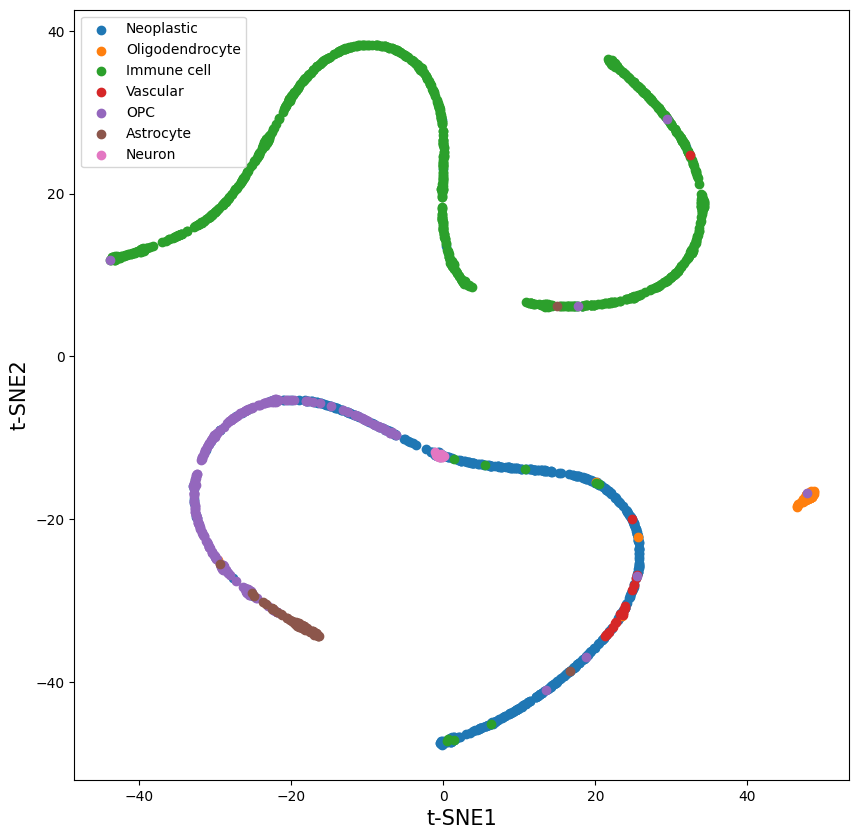

In [36]:
plt.figure(figsize=(10,10))

for label in tsne_embedding['cell_type'].unique():
    mask = tsne_embedding['cell_type'] == label
    plt.scatter(tsne_embedding[mask][1], tsne_embedding[mask][0], label=label)

plt.xlabel("t-SNE1", fontsize = 15)
plt.ylabel("t-SNE2", fontsize = 15)
plt.legend()

### 문제 : 세포들의 t-SNE, UMAP 차원축소 결과를 두 알고리즘의 local/global feature extraction capability와 연관하여 "비교" 설명해보세요.

- (힌트 : OPC, Oligodendrocyte, Astrocyte, Neuron은 전부 뇌세포의 일종으로 Immune Cell과는 발생 단계부터가 다른 세포입니다)

# 3. Clustering <a class="anchor" id="chapter3"></a>

## 3-1 | Implementation <a class="anchor" id="section_3_1"></a>

- 각 알고리즘 `class`로부터 `cluster_instance`를 초기화하여 사용합니다.
- 실제로 `데이터`를 클러스터링 할 때는, `cluster_instance.fit_predict(데이터)`의 형태로 사용합니다

1. `from sklearn.cluster`

  1.  K-Means : `KMeans(n_clusters = 목표 클러스터 수, random_state = 클러스터 중심 초기화 재현을 위한 random state 지정)`
  2. Agglomerative : `AgglomerativeClustering(n_clusters = 목표 클러스터 수, metric = 유사도 측정시 사용할 매트릭)`
  3. DBSCAN : `DBSCAN(eps = 두 데이터 포인트가 이웃으로 여겨질 수 있는 최대 거리/반경, min_samples = 클러스터를 형성하기 위한 최소 이웃 수)`

<br></br>

2. `from scipy.hierarchy`

  1. linkage : `linkage(데이터, method = 유사도 측정시 사용할 매트릭)`
    - 유일하게 `instance.fit_predict(데이터)` 문법을 사용하지 않는 클러스터링
    - linkage matrix를 리턴
  2. dendrogram : `dendrogram(linkage matrix : linkage() 함수로 얻은 linkage matrix)`
    - linkage matrix를 dendrogram으로 시각화


<br></br>

3. `from sklearn.mixture`

  1. GMM : `GaussianMixture(n_clusters = gaussian mixture 수, random_state = 클러스터 중심 초기화 재현을 위한 random state 지정)`


## 3-2 | Exercise <a class="anchor" id="section_3_2"></a>


In [37]:
# 클러스터링에 필요한 라이브러리와 클래스를 가져옵니다
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram

In [39]:
# 와인 데이터를 로드하고 전처리해줍니다
data = pd.read_csv("/content/drive/MyDrive/Regression_SVM_UnsupervisedLearning_ChangjaeIm/Unsupervised Learning/wine_data.csv")
print(data.head())

scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  
0                  

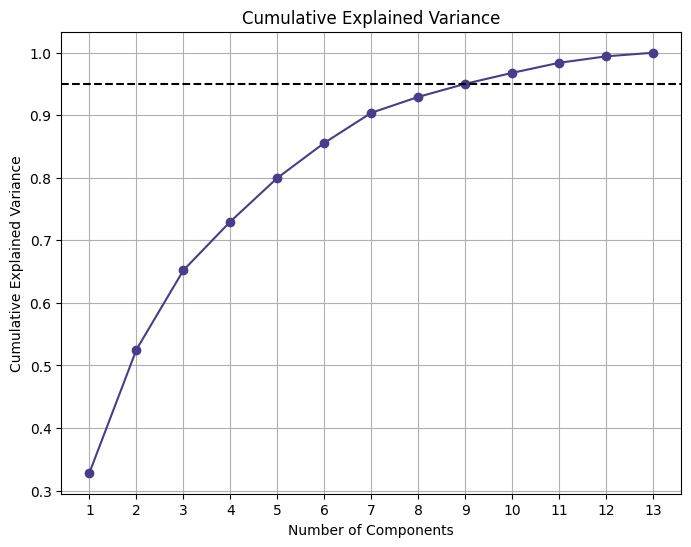

In [40]:
pca_wine = PCA(n_components = 13)
wine_embedding = pca_wine.fit_transform(scaled_data)

explained_variance = pca_wine.explained_variance_ratio_

#주성분에 따라 분산의 누적을 계산합니다.
cumulative_variance = np.cumsum(explained_variance)

#주성분 수에 따른 누적 분산 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='darkslateblue')
# y축 값이 0.95인 위치에 수평선을 그립니다
plt.axhline(y=0.95, color='black', linestyle='--')
plt.xticks(range(1,13+1))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid()
plt.show()

In [41]:
#최종적으로 지정해준 수 만큼 PCA 결과, 차원이 축소됩니다.
final_pca = PCA(n_components = 9)
final_embedding = final_pca.fit_transform(scaled_data)

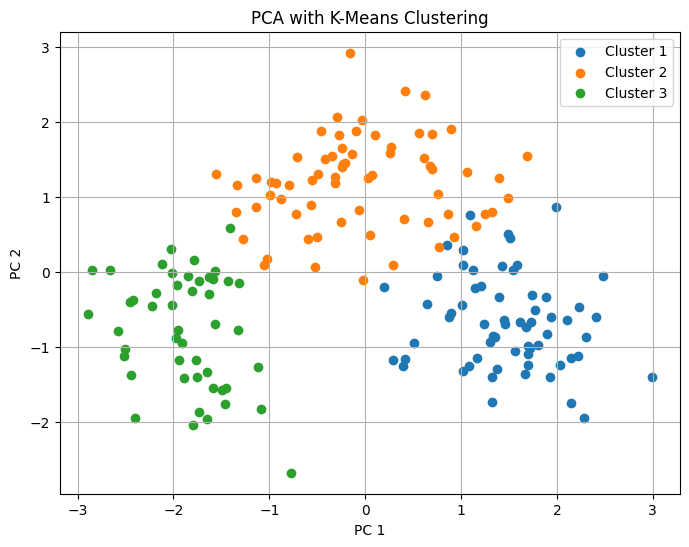

Clustering Time: 0.0358 seconds


In [44]:
#k-means Clustering을 수행합니다.
start_time = time.time()

n_centroids = 3

kmeans = KMeans(n_clusters = n_centroids, random_state = 17)
kmeans_clusters = kmeans.fit_predict(final_embedding)

end_time = time.time()
kmeans_time = end_time - start_time #k-means Clustering이 수행되는 시간을 구합니다.

#k-means Clustering 결과를 확인합니다.
plt.figure(figsize=(8, 6))
for cluster_num in range(n_centroids):
    plt.scatter(final_embedding[kmeans_clusters == cluster_num, 0],
                final_embedding[kmeans_clusters == cluster_num, 1],
                label=f'Cluster {cluster_num + 1}')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA with K-Means Clustering')
plt.legend()
plt.grid()
plt.show()

print(f"Clustering Time: {kmeans_time:.4f} seconds") #k-means Clustering이 수행되는 시간을 출력합니다.

In [46]:
#GMM Clustering을 수행합니다.
start_time = time.time()

n_gaussians = 3

gmm = GaussianMixture(n_components = n_gaussians, random_state=777)
gmm_clusters = gmm.fit_predict(final_embedding)

end_time = time.time()
gmm_time = end_time - start_time #GMM Clustering이 수행되는 시간을 구합니다.

#GMM Clustering 결과를 확인합니다.
plt.figure(figsize=(8, 6))
for cluster_num in range(n_gaussians):
    plt.scatter(final_embedding[gmm_clusters == cluster_num, 0],
                final_embedding[gmm_clusters == cluster_num, 1],
                label=f'Cluster {cluster_num + 1}')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA with GMM Clustering')
plt.legend()
plt.grid()
plt.show()

print(f"Clustering Time: {gmm_time:.4f} seconds") #GMM Clustering이 수행되는 시간을 출력합니다.

Clustering Time: 0.0538 seconds


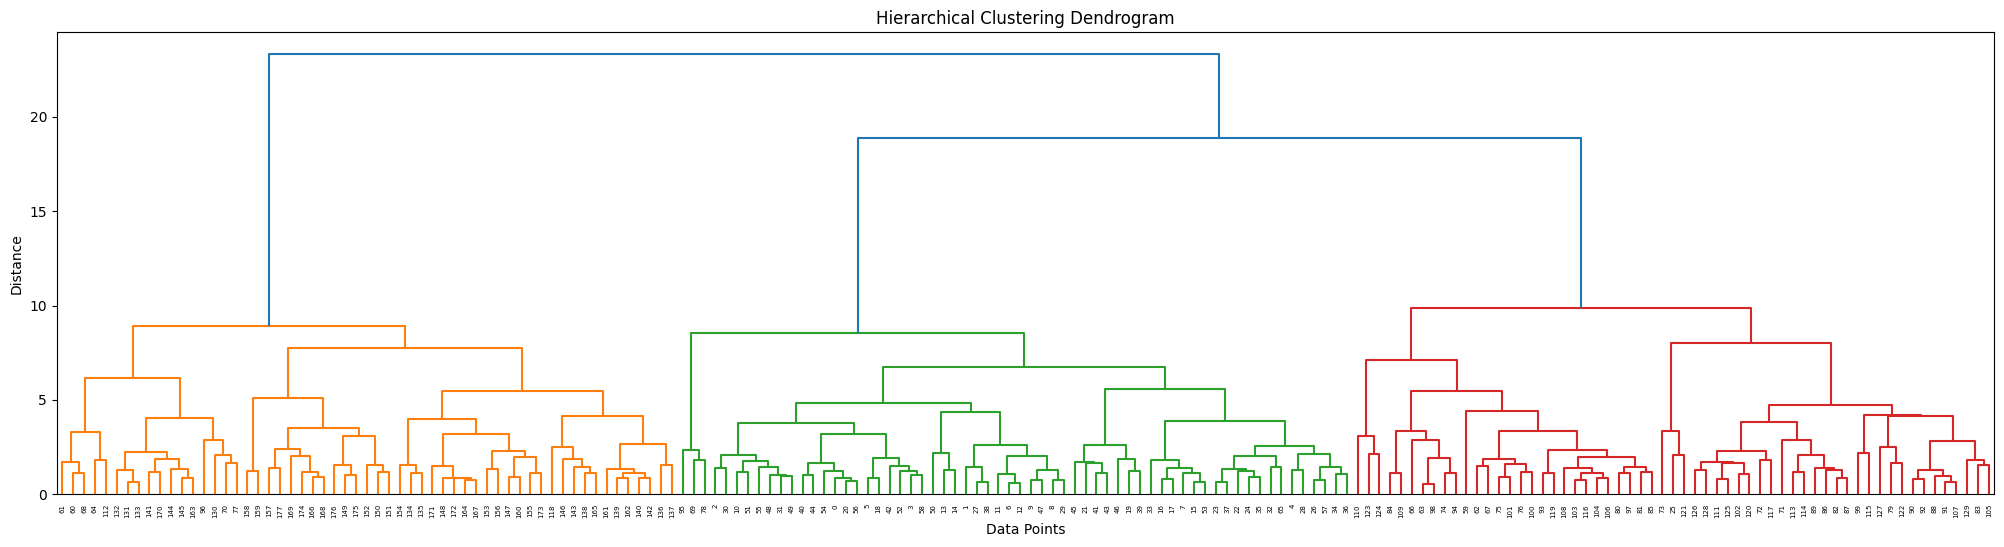

Clustering Time: 3.5025 seconds


In [47]:
#Hierarchical Clustering을 수행합니다.
start_time = time.time()

#덴드로그램을 그려봅니다.
linkage_matrix = linkage(final_embedding, method='ward')
plt.figure(figsize=(25, 6))
dendrogram(linkage_matrix, labels=None)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

n_clusters = 3

hierarchical = AgglomerativeClustering(n_clusters = n_clusters)
hierarchical_clusters = hierarchical.fit_predict(final_embedding)

end_time = time.time()
hierarchical_time = end_time - start_time #Hierarchical Clustering이 수행되는 시간을 구합니다.

#Hierarchical Clustering 결과를 확인합니다.
plt.figure(figsize=(8, 6))
for cluster_num in range(n_clusters):
    plt.scatter(final_embedding[hierarchical_clusters == cluster_num, 0],
                final_embedding[hierarchical_clusters == cluster_num, 1],
                label=f'Cluster {cluster_num + 1}')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA with Hierarchical Clustering')
plt.legend()
plt.grid()
plt.show()

print(f"Clustering Time: {hierarchical_time:.4f} seconds") #Hierarchical Clustering이 수행되는 시간을 출력합니다.

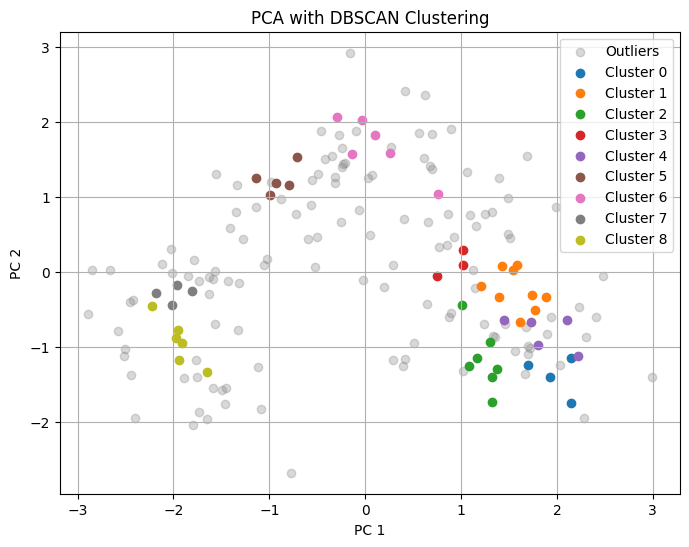

Clustering Time: 0.0126 seconds


In [63]:
#DBSCAN을 수행합니다.
start_time = time.time()

dbscan = DBSCAN(eps = 1, min_samples = 4)
dbscan_clusters = dbscan.fit_predict(final_embedding)

end_time = time.time()
dbscan_time = end_time - start_time #DBSCAN이 수행되는 시간을 구합니다.

#DBSCAN 결과를 확인합니다.
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(dbscan_clusters)
for cluster_num in unique_clusters:
    if cluster_num == -1:
        # Outliers are labeled as -1 in DBSCAN
        plt.scatter(final_embedding[dbscan_clusters == cluster_num, 0],
                    final_embedding[dbscan_clusters == cluster_num, 1],
                    label='Outliers', color='gray', alpha=0.3)
    else:
        plt.scatter(final_embedding[dbscan_clusters == cluster_num, 0],
                    final_embedding[dbscan_clusters == cluster_num, 1],
                    label=f'Cluster {cluster_num}')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA with DBSCAN Clustering')
plt.legend()
plt.grid()
plt.show()

print(f"Clustering Time: {dbscan_time:.4f} seconds") #DBSCAN이 수행되는 시간을 출력합니다.

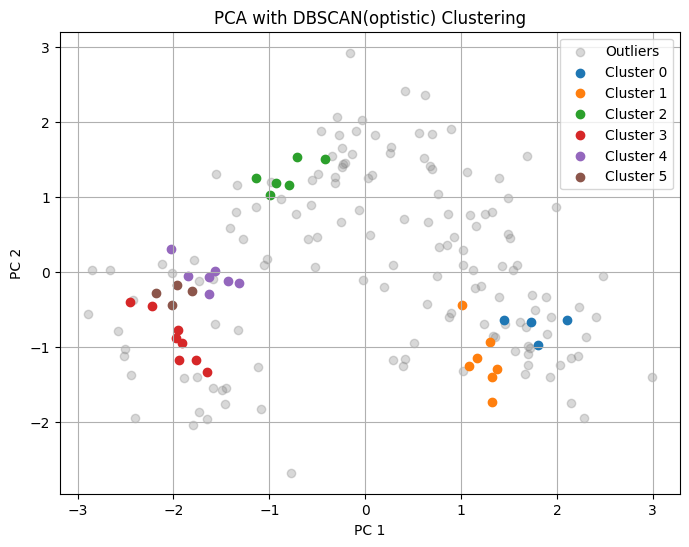

Clustering Time: 0.1307 seconds


In [64]:
#위에서 수행해보셨다면, 직접 변수를 지정하기 힘드셨을 겁니다. sklearn에서는 최적화된 eps를 구할 수 있는 패키지를 제공합니다!
from sklearn.cluster import OPTICS

start_time = time.time()

optics = OPTICS(min_samples=4) #추가로, 2차원에서 클러스터링을 할 때 DBSCAN은 minPts = 4로 지정하다는 것이 가장 좋다는 논문 내용이 있습니다!
clusters = optics.fit_predict(final_embedding)

end_time = time.time()
clustering_time = end_time - start_time

plt.figure(figsize=(8, 6))
unique_clusters = np.unique(clusters)
for cluster_num in unique_clusters:
    if cluster_num == -1:
        # Outliers are labeled as -1 in OPTICS
        plt.scatter(final_embedding[clusters == cluster_num, 0],
                    final_embedding[clusters == cluster_num, 1],
                    label='Outliers', color='gray', alpha=0.3)
    else:
        plt.scatter(final_embedding[clusters == cluster_num, 0],
                    final_embedding[clusters == cluster_num, 1],
                    label=f'Cluster {cluster_num}')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA with DBSCAN(optistic) Clustering')
plt.legend()
plt.grid()
plt.show()

print(f"Clustering Time: {clustering_time:.4f} seconds")